In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pickle
import json
import geopandas as gpd
from shapely.wkt import loads
from pyproj import Proj, Transformer

In [95]:

def lat_lon_to_axis(lat, lon, axis_direction=(1, 0), crs="EPSG:3857", length_of_df=len(main_df)):
    """
    Convert latitude and longitude to a one-dimensional value in meters along an axis.

    Args:
        lat (float): Latitude of the point.
        lon (float): Longitude of the point.
        axis_direction (tuple): Direction vector of the axis (x, y).
        crs (str): CRS for projecting to meters (default: EPSG:3857).

    Returns:
        float: One-dimensional projection value in meters.
    """
    
    # Define the transformer for projecting lat/lon to the desired CRS
    transformer = Transformer.from_crs("EPSG:4326", crs, always_xy=True)
    
    # Project the latitude and longitude to meters
    x, y = transformer.transform(lon, lat)
    
    # Normalize the axis direction vector
    axis_vector = np.array(axis_direction)
    axis_unit_vector = axis_vector / np.linalg.norm(axis_vector)
    
    # Compute the projection of the point onto the axis
    projection_value = np.dot([x, y], axis_unit_vector)
    return projection_value

In [87]:
# loading the main dataframe
main_df = pd.read_csv("20181024_d1_0830_0900_segmented_oneaxistrajectory_traffic.csv")
# loading the traffic light states
with open("20181024_d1_0830_0900_traffic_light_states.json") as f:
    traffic_info = json.load(f)
# loading the segments
segments_gdf = gpd.read_file("20181024_d1_0830_0900_segments.csv")
# Convert to GeoDataFrame
if "geometry" in segments_gdf.columns:
    # Convert 'geometry' to shapely objects if needed
    segments_gdf["geometry"] = segments_gdf["geometry"].apply(loads)
    # Create GeoDataFrame and set the CRS to WGS 84 (latitude/longitude)
    segments_gdf = gpd.GeoDataFrame(segments_gdf, geometry="geometry", crs="EPSG:4326")
else:
    raise ValueError("The DataFrame does not have a 'geometry' column.")

# Reproject to a projected CRS (replace EPSG code with appropriate UTM zone)
segments_gdf = segments_gdf.to_crs("EPSG:25832")  # Example for UTM Zone 32N

# Calculate lengths
segments_gdf["length"] = segments_gdf.geometry.length

pos_1_one_axis_trajectory = []
pos_2_one_axis_trajectory = []
for i, row in segments_gdf.iterrows():
    pos_1_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[0][1], row.geometry.coords.xy[0][0], crs="EPSG:4326"))
    pos_2_one_axis_trajectory.append(lat_lon_to_axis(row.geometry.coords.xy[1][1], row.geometry.coords.xy[1][0], crs="EPSG:4326"))
    
# Calculate total length
total_length = segments_gdf["length"].sum()

# loading the traffic lights
traffic_lights_df = pd.read_csv("traffic_lights.csv")
# loading the traffic light states
with open("traffic_info_dict.pkl", "rb") as f:
    traffic_lights_dict_states = pickle.load(f)

3540895.9335678415 3540931.3110104282
2953793.230950274 2953774.2609228157
3540860.55627133 3540895.9335678415
2953812.2009618557 2953793.230950274
3540825.179120892 3540860.55627133
2953831.1709575616 2953812.2009618557
3540789.802116527 3540825.179120892
2953850.1409373945 2953831.1709575616
3540754.425258234 3540789.802116527
2953869.1109013567 2953850.1409373945
3540719.048546014 3540754.425258234
2953888.080849448 2953869.1109013567
3540683.6719798627 3540719.048546014
2953907.050781672 2953888.080849448
3540648.295559783 3540683.6719798627
2953926.0206980295 2953907.050781672
3540612.919285772 3540648.295559783
2953944.9905985226 2953926.0206980295
3540577.5431578294 3540612.919285772
2953963.9604831524 2953944.9905985226
3540542.167175955 3540577.5431578294
2953982.930351922 2953963.9604831524
3540506.5442576013 3540542.167175955
2953982.3800159544 2953982.930351922
3540470.735660312 3540506.5442576013
2953967.1568843285 2953982.3800159544
3540434.9270840175 3540470.735660312
29

In [ ]:
print(lat_lon_to_axis(main_df.iloc[0].lat, main_df.iloc[1].lon))


2642236.575465186
2642236.3528262046


# Define the constants

In [44]:
DISTANCE_THRESHOLD = 5

# Normalize the one axis trajectory

In [48]:
from CTM_class import CTMParameters, initialize_density, update_cell_status
from helper import veh_to_density
from sklearn.preprocessing import normalize

# Initialize CTM parameters
ctm_params = CTMParameters()
ctm_params.cell_length = segments_gdf["length"].mean()

# Initialize densities for each segment
segment_densities = {idx: initialize_density() for idx in segments_gdf.index}

# Truncate points that are too far from the main corridor line
main_df_truncated = main_df[main_df["temp_distance"] < DISTANCE_THRESHOLD].copy()  # Ensure it's a copy

# Normalize trajectory
normalized_trajectory = (
    main_df_truncated["one_axis_trajectory"] - main_df_truncated["one_axis_trajectory"].min()
)
normalized_trajectory = normalized_trajectory / normalized_trajectory.max() * segments_gdf["length"].sum()

# Assign to the DataFrame safely
main_df_truncated.loc[:, "normalized_trajectory"] = normalized_trajectory


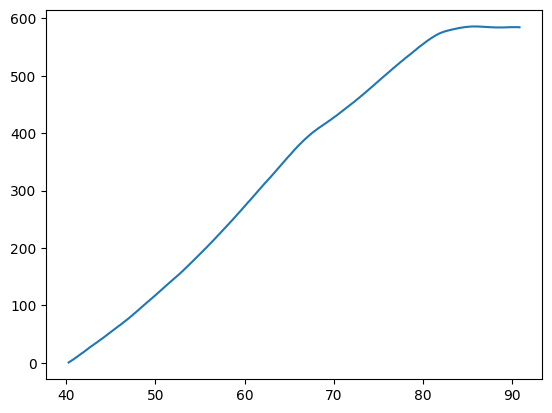

In [51]:
main_df_truncated

,lat,lon,speed,lon_acc,lat_acc,time,dist_to_start,dist_to_end,veh_id,segment_id,temp_distance,one_axis_trajectory,closest_traffic_light,distance_to_traffic_light,normalized_trajectory
0,37.979949,23.735613,29.3152,-0.1790,-0.0253,0.00,9.254831,459.678657,32.0,1.0,3.190766,2.642236e+06,0,43.220861,63.437439
1,37.979946,23.735615,29.2910,-0.1578,-0.0291,0.04,9.586996,459.303356,32.0,1.0,3.224027,2.642237e+06,0,43.597100,63.916212
2,37.979944,23.735617,29.2684,-0.1552,-0.0329,0.08,9.857971,459.030760,32.0,1.0,3.188256,2.642237e+06,0,43.873348,64.394986
3,37.979941,23.735619,29.2469,-0.1446,-0.0366,0.12,10.194706,458.655467,32.0,1.0,3.221517,2.642237e+06,0,44.249611,64.873759
4,37.979939,23.735621,29.2288,-0.1061,-0.0403,0.16,10.467632,458.382890,32.0,1.0,3.185746,2.642237e+06,0,44.525965,65.352532
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
672406,37.980044,23.735572,28.9885,0.3464,0.7262,818.64,6.830528,470.813214,918.0,0.0,0.196335,2.642232e+06,0,32.183260,53.622590
672407,37.980041,23.735574,29.0103,0.3757,0.7476,818.68,6.678863,470.437966,918.0,0.0,0.229596,2.642232e+06,0,32.559763,54.101363
672408,37.980039,23.735576,29.0349,0.3894,0.7668,818.72,6.627068,470.165489,918.0,0.0,0.193825,2.642232e+06,0,32.838304,54.580136
672409,37.980036,23.735577,29.0621,0.4186,0.7833,818.76,6.446423,469.823714,918.0,0.0,0.314004,2.642232e+06,0,33.173530,54.819523


In [82]:
segments_gdf

,geometry,length,pos_1_one_axis_trajectory,pos_2_one_axis_trajectory
0,"LINESTRING (3540931.311 2953774.261, 3540895.9...",40.142563,NaN,NaN
1,"LINESTRING (3540895.934 2953793.231, 3540860.5...",40.142427,NaN,NaN
2,"LINESTRING (3540860.556 2953812.201, 3540825.1...",40.142291,NaN,NaN
3,"LINESTRING (3540825.179 2953831.171, 3540789.8...",40.142155,NaN,NaN
4,"LINESTRING (3540789.802 2953850.141, 3540754.4...",40.142018,NaN,NaN
5,"LINESTRING (3540754.425 2953869.111, 3540719.0...",40.141882,NaN,NaN
6,"LINESTRING (3540719.049 2953888.081, 3540683.6...",40.141746,NaN,NaN
7,"LINESTRING (3540683.672 2953907.051, 3540648.2...",40.141610,NaN,NaN
8,"LINESTRING (3540648.296 2953926.021, 3540612.9...",40.141473,NaN,NaN
9,"LINESTRING (3540612.919 2953944.991, 3540577.5...",40.141337,NaN,NaN
